In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os
print(tf.config.list_physical_devices('GPU'))

In [ ]:
train_path = "/mnt/c/LungCancerCT/CTscans"
data_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      validation_split=0.15,
      fill_mode='nearest')

train_generator = data_generator.flow_from_directory(train_path,
                                                    class_mode="binary",
                                                    subset="training",
                                                    target_size=(224, 224),)
validation_generator = data_generator.flow_from_directory(train_path,
                                                    class_mode="binary",
                                                    subset="validation",
                                                    target_size=(224, 224),)
conv_base = MobileNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks=[early_stopping])


In [4]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block_16_expand':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

new_history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stopping])

Epoch 1/20
24/24 [==============================] - 20s 630ms/step - loss: 0.6160 - accuracy: 0.9599 - val_loss: 0.7548 - val_accuracy: 0.9077
Epoch 2/20
24/24 [==============================] - 15s 623ms/step - loss: 0.5666 - accuracy: 0.9759 - val_loss: 0.6012 - val_accuracy: 0.9615
Epoch 3/20
24/24 [==============================] - 15s 608ms/step - loss: 0.5876 - accuracy: 0.9652 - val_loss: 0.5639 - val_accuracy: 0.9769
Epoch 4/20
24/24 [==============================] - 14s 604ms/step - loss: 0.5704 - accuracy: 0.9679 - val_loss: 0.6134 - val_accuracy: 0.9462
Epoch 5/20
24/24 [==============================] - 15s 609ms/step - loss: 0.5693 - accuracy: 0.9666 - val_loss: 0.6366 - val_accuracy: 0.9308
Epoch 6/20
24/24 [==============================] - 15s 612ms/step - loss: 0.5603 - accuracy: 0.9733 - val_loss: 0.5825 - val_accuracy: 0.9692
Epoch 7/20
24/24 [==============================] - 15s 625ms/step - loss: 0.5443 - accuracy: 0.9746 - val_loss: 0.7171 - val_accuracy: 0.9231

In [6]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

average_train_accuracy = sum(train_accuracy) / len(train_accuracy)
average_val_accuracy = sum(val_accuracy) / len(val_accuracy)
accuracy_difference = average_train_accuracy - average_val_accuracy

average_train_loss = sum(train_loss) / len(train_loss)
average_val_loss = sum(val_loss) / len(val_loss)

print(f"Average Training Accuracy: {average_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {average_val_accuracy:.4f}")
print(f"Difference: {accuracy_difference:.4f}")

print(f"Average Training loss: {average_train_loss:.4f}")
print(f"Average Validation loss: {average_val_loss:.4f}")

Average Training Accuracy: 0.9660
Average Validation Accuracy: 0.9381
Difference: 0.0279
Average Training loss: 0.5884
Average Validation loss: 0.6560


In [5]:
history.history['accuracy'].extend(new_history.history['accuracy'])
history.history['val_accuracy'].extend(new_history.history['val_accuracy'])
history.history['loss'].extend(new_history.history['loss'])
history.history['val_loss'].extend(new_history.history['val_loss'])

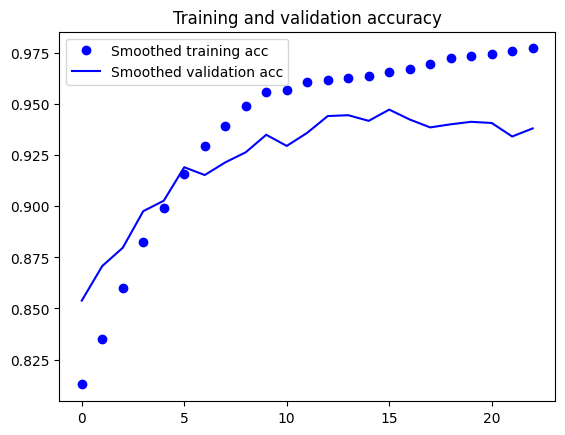

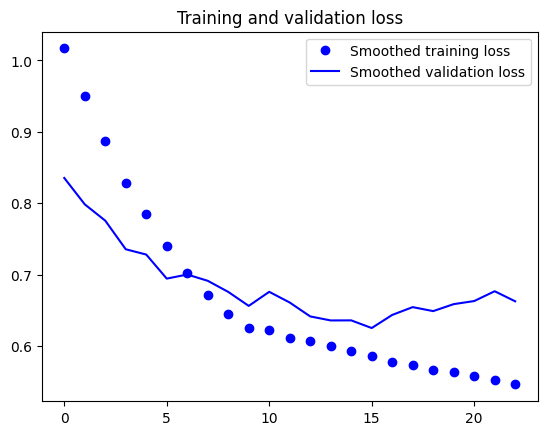

In [7]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
test_path = "/mnt/c/LungCancerCT/final_test_images"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)

# model.save('MobileNetV2.keras')

Found 99 images belonging to 2 classes.
4/4 [==============================] - 2s 588ms/step - loss: 0.5023 - accuracy: 1.0000
test acc: 1.0
